# Ensemble Learning through Bagging 

**bagging == Bootstrapping Aggregation** 

$\implies$  hyperparam = {M = #learners, alpha = # relative trainset size}


In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *
from basic_estimator_model import *

## Parameter Configuration

In [13]:
np.random.seed(2020)

In [14]:
N_train = 2000
N_test = 100000
d = 1
T = 2

In [15]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [16]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [17]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [18]:
#prepare datasets & values
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = y_test  
V_0 = s_test.generate_true_V(0)

V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.07925421829077972

In [19]:
# 
def Flatten_Training_Sample(X , f):
    return np.array([f(x) for x in X])
#Shape of each sample j: [X_j[0,0],... ,X_j[d,0],...,X_j[0,T] , ..., X_j[d,T]]
Flatten_X_1_train = Flatten_Training_Sample(X_train, lambda x : x.T.flatten())
Flatten_X_1_test = Flatten_Training_Sample(X_test, lambda x : x.T.flatten())


## Create Custom Models
(to have more control of splitting etc)

In [29]:
from sklearn.base import clone, BaseEstimator

class BaggingBaseClass(BaseEstimator):
    def __init__(self,M,predictor):
        super().__init__()
        self.M = M
        self.predictor = predictor
        self.predictors = None
        
    def _split_train_set(self,X,y):
        raise NotImplementedError
    
    def fit(self,X,y):
        self.predictors  = [clone(self.predictor)] *self.M # do it here to ensure using latest version of M
        X_list,y_list = self._split_train_set(X,y)
        for i in range(self.M):
            self.predictors[i].fit(X_list[i],y_list[i])
    
    def predict(self,X):
        predictions = np.zeros((X.shape[0]))
        for i in range(self.M):
            predictions = predictions + self.predictors[i].predict(X)
        predictions = predictions / self.M 
        return predictions

class SimpleBagger(BaggingBaseClass):
    def __init__(self,M,train_size_alpha,predictor):
        super(SimpleBagger,self).__init__(M,predictor)
        self.train_size_alpha = train_size_alpha
     
    def _split_train_set(self,X,y):
        n = round(X.shape[0]*self.train_size_alpha)
        X_list = []
        y_list = []
        for i in range(self.M):
            indices = np.random.choice(X.shape[0],size=n,replace=True)
            X_list.append(X[indices])
            y_list.append(y[indices])
        return X_list, y_list
    
    '''def _split_train_set(self,X,y):
        """
        With replacement in between train sets, not within sets
        """
        n = round(X.shape[0]*self.train_size_alpha)
        X_list = []
        y_list = []
        for i in range(self.M):
            X_list.append(X[np.random.choice(X.shape[0],size=n,replace=False)])
            y_list.append(y[np.random.choice(y.shape[0],size=n,replace=False)])
        return X_list, y_list'''
    
s = SimpleBagger(11,0.5,None)
s.get_params()

{'M': 11, 'predictor': None, 'train_size_alpha': 0.5}

## GridSearch

nB: cannot use Scikit gridsearch as it performs CV and we want to have a different test set of a larger size!

In [30]:

def normalized_error_VT(y_hat,y,V_0):
        #y_hat= f_X predicted
        # y = V_T = f_X
        Normalized_Error_T = np.sqrt(1/len(y)*np.sum((y_hat-y)**2, axis=0))/V_0
        ## see formula p4 for ||f(X)||2,Q t
        ## since samples are drawn according to measure - just sum them up
        return Normalized_Error_T


In [31]:
from multiprocessing import  cpu_count,current_process
from multiprocessing.pool import ThreadPool
import functools
import threading

# define your custom function for passing into each thread
def create_logger(m,alpha,trial,log):
    def logger(x):
        print(f"{m},{alpha},{trial} -> {x}")
        log.append([m,alpha,trial,x])
    return logger

def calc_normalized_error(m,alpha, X_train, y_train, N_test,d, DeltaT, base_model,trial):
    """
    Train given model on given dataset, afterwards create a new test set of size N_test and determine
    the normalized Error
    
    uses:
    - normalized_error_VT
    - Flatten_Training_Sample
    """
    print(f" {m},{alpha},{trial} -> thread id = {threading.current_thread().ident}")
    model = clone(base_model)
    model.M = m
    model.train_size_alpha = alpha
    model.fit(X_train,y_train)
    s_test = MaxCallStochasticModel(N_test, d, DeltaT)
    s_test.generate_samples()
    y_test = s_test.y
    X_test = s_test.X
    S_test = s_test.S

    Flatten_X_test = Flatten_Training_Sample(X_test, lambda x : x.T.flatten())

    V_T = y_test  
    V_0 = s_test.generate_true_V(0)
    V_0= V_0.mean()
    y_hat = model.predict(Flatten_X_test)
    error = normalized_error_VT(y_hat,V_T,V_0).item()
    return error

# GRIDSEARCH PARAMS
model = SimpleBagger(0,0,GaussianProcessRegressor(kernel))
trials = 1
M_grid = [1,2,3,4,5,6,7,8]
alpha_grid = [0.1,0.2,0.5,0.7,0.9,1.0]
results = []

### ACTUAL GRIDSEARCH
pool = ThreadPool(cpu_count())
for trial in range(trials):
    for m in M_grid:
        for alpha in alpha_grid:
            pool.apply_async(calc_normalized_error, args=(m,alpha,Flatten_X_1_train,y_train,N_test,1, [1/12,11/12], model,trial),callback = create_logger(m,alpha,trial,results))
pool.close()
pool.join()

converted_results = np.ones((len(M_grid),len(alpha_grid),trials))*(-1)
for item in results:
    converted_results[M_grid.index(item[0]),alpha_grid.index(item[1]),item[2]] = item[3]


 1,0.1,0 -> thread id = 7588 1,0.2,0 -> thread id = 9700

 1,0.5,0 -> thread id = 18276
 1,0.7,0 -> thread id = 12888
 1,0.9,0 -> thread id = 21496
 1,1.0,0 -> thread id = 7032
 2,0.1,0 -> thread id = 6700
 2,0.2,0 -> thread id = 17384
 2,0.5,0 -> thread id = 3588
 2,0.7,0 -> thread id = 10076
 2,0.9,0 -> thread id = 20808
 2,1.0,0 -> thread id = 6528


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 3,0.1,0 -> thread id = 7588
1,0.1,0 -> 0.33075022934712606
 3,0.2,0 -> thread id = 67002,0.1,0 -> 0.45425184462732565

 3,0.5,0 -> thread id = 9700
1,0.2,0 -> 0.5373781878603506
1,0.5,0 -> 0.3224780753892159 3,0.7,0 -> thread id = 18276

 3,0.9,0 -> thread id = 173842,0.2,0 -> 0.35069600013771574



c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


3,0.1,0 -> 0.21841783674754056 3,1.0,0 -> thread id = 7588

2,0.5,0 -> 0.2289455773859458 4,0.1,0 -> thread id = 3588

 4,0.2,0 -> thread id = 6700
3,0.2,0 -> 0.29854293165351337
 4,0.5,0 -> thread id = 128881,0.7,0 -> 0.2211902486644411

 4,0.7,0 -> thread id = 70321,1.0,0 -> 0.26741059030268094

 4,0.9,0 -> thread id = 214961,0.9,0 -> 0.22100803123522067

 4,1.0,0 -> thread id = 35884,0.1,0 -> 0.44145186554453947

 5,0.1,0 -> thread id = 100762,0.7,0 -> 0.2545933960131064

 5,0.2,0 -> thread id = 208082,0.9,0 -> 0.22343854189544504

 5,0.5,0 -> thread id = 65282,1.0,0 -> 0.23301156493649006



c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 5,0.7,0 -> thread id = 67004,0.2,0 -> 0.23183512960080843

5,0.1,0 -> 0.45331818027511855 5,0.9,0 -> thread id = 10076

 5,1.0,0 -> thread id = 208085,0.2,0 -> 0.3357835565350766

3,0.5,0 -> 0.19927643683504445 6,0.1,0 -> thread id = 9700

 6,0.2,0 -> thread id = 12888
4,0.5,0 -> 0.22495862441473274
 6,0.5,0 -> thread id = 182763,0.7,0 -> 0.19864873666294325

 6,0.7,0 -> thread id = 97006,0.1,0 -> 0.5469183873868739

 6,0.9,0 -> thread id = 65285,0.5,0 -> 0.225243385684199

 6,1.0,0 -> thread id = 70324,0.7,0 -> 0.21407343033016482

 7,0.1,0 -> thread id = 173843,0.9,0 -> 0.1932039044336573

 7,0.2,0 -> thread id = 75883,1.0,0 -> 0.30337300443437815

 7,0.5,0 -> thread id = 128886,0.2,0 -> 0.30075172171199005

 7,0.7,0 -> thread id = 21496
4,0.9,0 -> 0.22644754483127766


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


 7,0.9,0 -> thread id = 17384
7,0.1,0 -> 0.5498721020806002


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


7,0.2,0 -> 0.2538805120907184 7,1.0,0 -> thread id = 7588

 8,0.1,0 -> thread id = 128887,0.5,0 -> 0.28099880187980714

 8,0.2,0 -> thread id = 182766,0.5,0 -> 0.24187187245275485

 8,0.7,0 -> thread id = 9700 8,0.5,0 -> thread id = 67005,0.7,0 -> 0.23330479214502509

6,0.7,0 -> 0.16147891308390255

 8,0.9,0 -> thread id = 128888,0.1,0 -> 0.3455581657699031

7,0.7,0 -> 0.2000648783329886 8,1.0,0 -> thread id = 21496

8,0.2,0 -> 0.26381018693120145
6,0.9,0 -> 0.20952773444298542
4,1.0,0 -> 0.2924169558272424
5,0.9,0 -> 0.23808458302188934


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


5,1.0,0 -> 0.1390423653314788
6,1.0,0 -> 0.22196070753260572


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


7,0.9,0 -> 0.21499075888422225
8,0.5,0 -> 0.19886860842844506
8,0.9,0 -> 0.24412634487964435
8,0.7,0 -> 0.2871003150872592
7,1.0,0 -> 0.3378704117796324
8,1.0,0 -> 0.21068545509849196


In [32]:
print(converted_results.shape)
print(converted_results)

(8, 6, 1)
[[[0.33075023]
  [0.53737819]
  [0.32247808]
  [0.22119025]
  [0.22100803]
  [0.26741059]]

 [[0.45425184]
  [0.350696  ]
  [0.22894558]
  [0.2545934 ]
  [0.22343854]
  [0.23301156]]

 [[0.21841784]
  [0.29854293]
  [0.19927644]
  [0.19864874]
  [0.1932039 ]
  [0.303373  ]]

 [[0.44145187]
  [0.23183513]
  [0.22495862]
  [0.21407343]
  [0.22644754]
  [0.29241696]]

 [[0.45331818]
  [0.33578356]
  [0.22524339]
  [0.23330479]
  [0.23808458]
  [0.13904237]]

 [[0.54691839]
  [0.30075172]
  [0.24187187]
  [0.16147891]
  [0.20952773]
  [0.22196071]]

 [[0.5498721 ]
  [0.25388051]
  [0.2809988 ]
  [0.20006488]
  [0.21499076]
  [0.33787041]]

 [[0.34555817]
  [0.26381019]
  [0.19886861]
  [0.28710032]
  [0.24412634]
  [0.21068546]]]


In [33]:
masked_results= np.ma.masked_where(converted_results <= 0.0,converted_results) # some runs have been aborted every now and then -> filter them out
means = masked_results.mean(axis=2)
sigmas = masked_results.std(axis=2)
means.shape

(8, 6)

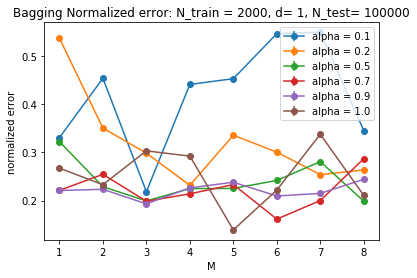

In [34]:
for i in range(len(alpha_grid)):
    plt.errorbar(np.array(M_grid),means[:,i],sigmas[:,i],marker ='o',label = f"alpha = {alpha_grid[i]}")
plt.title(f"Bagging Normalized error: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("M")
plt.xticks(M_grid)
plt.ylabel("normalized error")
plt.legend()
plt.show()

## Store results

In [53]:
res_dict = {'N_train': N_train, 'N_test': N_test,'mgrid': M_grid, 'alpha_grid': alpha_grid, 'errors': converted_results.tolist()}

In [54]:
import json
import datetime
with open(f'bagging_w_replacement_{str(datetime.date.today())}.json', 'w') as fp:
    json.dump(res_dict, fp)